# **DESAFIO 3 G2** 
# **Dataset Properati - Modelado de datos - Preliminar.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#sec_intro)

Observaciones preliminares dataset

$\hspace{.5cm}$[Importaciones y carga de dataset](#sec_imp)

$\hspace{.5cm}$[Analisis previos y distribuciones de variables](#sec_adv)
  
$\hspace{.5cm}$[Imputaciones](#sec_imp)

$\hspace{.5cm}$[Outliers](#sec_outliers)

$\hspace{.5cm}$[Variables dummies](#sec_dummies)

Vacio

$\hspace{.5cm}$[Expresiones regulares](#section_re)

$\hspace{.9cm}$[Principios generales](#section_re_pg)

Vacio

$\hspace{.5cm}$[Borrado de registros duplicados](#section_drd)

$\hspace{.5cm}$[Borrado de registros sin información completa](#section_drii)

Visualizaciones basicas

$\hspace{.5cm}$[Venta departamentos CABA](#section_v_1)

$\hspace{.5cm}$[Venta casas CABA, Buenos Aires e Interior](#section_v_4)





---



### Importacion y carga del dataset

In [1]:
import pandas as pd
import numpy as np
import re
import random

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
pd.set_option('display.max_colwidth', 1500)
pd.set_option('display.max_rows', 400)

In [4]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [5]:
data_location = 'https://github.com/DHDSDesafios/DH_DS_desafio_2_properati/raw/master/data/properatid2caba.zip'
data = pd.read_csv(data_location, compression='zip', encoding="utf-8")

In [6]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [7]:
data.shape

(29380, 39)

In [8]:
data.sample(3)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
24785,100719,apartment,|Argentina|Capital Federal|Villa del Parque|,Argentina,Capital Federal,NaN,NaN,NaN,120100.0,USD,...,1.0,NaN,NaN,balcon,NaN,1.0,NaN,NaN,NaN,1.0
4951,23257,apartment,|Argentina|Capital Federal|Retiro|,Argentina,Capital Federal,"-34.6002250344,-58.3797039752",-34.600225,-58.379704,90000.0,USD,...,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
27872,116782,apartment,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,NaN,NaN,NaN,238218.0,USD,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


---
## Analisis previos y distribuciones de variables

datosCol(serie) - Funcion que retorna diccionario con los datos de una Serie / Columna del DataFrame a analizar:

Campos:
 - nombre columna.
 - tipo de dato Pandas serie.
 - cantidad de registros en la serie.
 - cantidad de nulos en la serie.
 - cantidad de NO nulos en la serie.
 - porcentaje de No nulos en la serie.
 - cantidad de valores unicos en la serie.
 - valor mas repetido en la serie.
 - valor maximo en la serie.
 - valor minimos en la serie.
 - media, mediana y desvio estandar en la serie.
 - distribucion de cuantiles.
 - tipos de datos sobre los valores incluidos en la serie.

In [9]:
def datosCol(col=None):
    try:
        if col.dtype != object:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': int(len(col) - col.describe()[0]), 
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(len(col.value_counts())),
                    'mas_repetido': col.value_counts().index[0],
                    'minimo': round(col.min(), 2),
                    'maximo': round(col.max(), 2),
                    'media': round(col.describe()[1], 2),
                    'mediana': col.median(),
                    'desvio': round(col.describe()[2], 2),
                    'q25': col.describe()[4],
                    'q50': col.describe()[5],
                    'q75': col.describe()[6],
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
        else:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': col.isnull().sum(),
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(col.describe()[1]), 
                    'mas_repetido': col.describe()[2],
                    'nulos': col.isnull().sum(),
                    'frecuencia': int(col.describe()[3]),
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
    except:
        return 'use a valid pandas Series'

In [10]:
data_info = pd.DataFrame([datosCol(data[x]) for x in ['property_type', 'place_name', 'price_aprox_usd', 'floor', 'rooms',
                                                      'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
                                                      'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
                                                      'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus'] ])
data_info

,nombre,series_dt,nulos,nulos_porcentaje,unicos,mas_repetido,frecuencia,values_dt,minimo,maximo,media,mediana,desvio,q25,q50,q75
0,property_type,object,0,0.00,4,apartment,24713.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,place_name,object,0,0.00,62,Belgrano,2745.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,price_aprox_usd,float64,1532,5.21,5237,120000,NaN,[<class 'float'>],5103.61,46545445.00,263567.97,155000.00,452774.30,104724.465,155000.00,278000.00
3,floor,float64,26480,90.13,82,1,NaN,[<class 'float'>],1.00,2509.00,12.64,4.00,83.22,2.000,4.00,7.00
4,rooms,float64,11341,38.60,17,2,NaN,[<class 'float'>],1.00,22.00,2.55,2.00,1.47,1.000,2.00,3.00
5,price_usd_per_m2,float64,7227,24.60,10452,2500,NaN,[<class 'float'>],13.80,206333.33,3146.57,2486.41,3722.99,1988.950,2486.41,3094.27
6,price_per_m2,float64,2512,8.55,12115,2500,NaN,[<class 'float'>],3.21,2600000.00,3839.77,2727.27,18864.14,2177.420,2727.27,3440.00
7,surface_total_in_m2,float64,3638,12.38,734,40,NaN,[<class 'float'>],0.00,200000.00,116.88,62.00,1268.88,42.000,62.00,110.00
8,surface_covered_in_m2,float64,1170,3.98,620,30,NaN,[<class 'float'>],0.00,10958.00,91.43,55.00,203.58,38.000,55.00,95.00
9,cochera,float64,19299,65.69,1,1,NaN,[<class 'float'>],1.00,1.00,1.00,1.00,0.00,1.000,1.00,1.00


Estadarizacion de valores de amenities.

In [11]:
data.loc[data.balcon.notnull(), 'balcon'] = 1
data.loc[data.balcon.isnull(), 'balcon'] = 0
data.balcon.astype('uint8')

data.loc[data.cochera.isnull(), 'cochera'] = 0
data.cochera.astype('uint8')

data.loc[data.piscina.isnull(), 'piscina'] = 0
data.piscina.astype('uint8')

data.loc[data.lavadero.isnull(), 'lavadero'] = 0
data.lavadero.astype('uint8')

data.loc[data.parrilla.isnull(), 'parrilla'] = 0
data.parrilla.astype('uint8')

data.loc[data.terraza.isnull(), 'terraza'] = 0
data.terraza.astype('uint8')

data.loc[data.jardin.isnull(), 'jardin'] = 0
data.jardin.astype('uint8')

data.loc[data.baulera.isnull(), 'baulera'] = 0
data.baulera.astype('uint8')

data.loc[data.seguridad.isnull(), 'seguridad'] = 0
data.seguridad.astype('uint8')

data.loc[data.metrobus.isnull(), 'metrobus'] = 0
data.metrobus.astype('uint8')

data.loc[data.subte.isnull(), 'subte'] = 0
data.subte.astype('uint8')

0        0
1        0
2        0
3        0
4        0
        ..
29375    0
29376    0
29377    0
29378    0
29379    1
Name: subte, Length: 29380, dtype: uint8

Graficos basicos de visualizacion

In [12]:
prop_apartment = data.property_type == 'apartment'
prop_store = data.property_type == 'store'
prop_ph = data.property_type == 'PH'
prop_house = data.property_type == 'house'

### Distribuciones basicas de campos numericos continuos

 * 'price_per_m2'
 * 'price_usd_per_m2'
 * 'surface_total_in_m2'
 * 'surface_covered_in_m2'

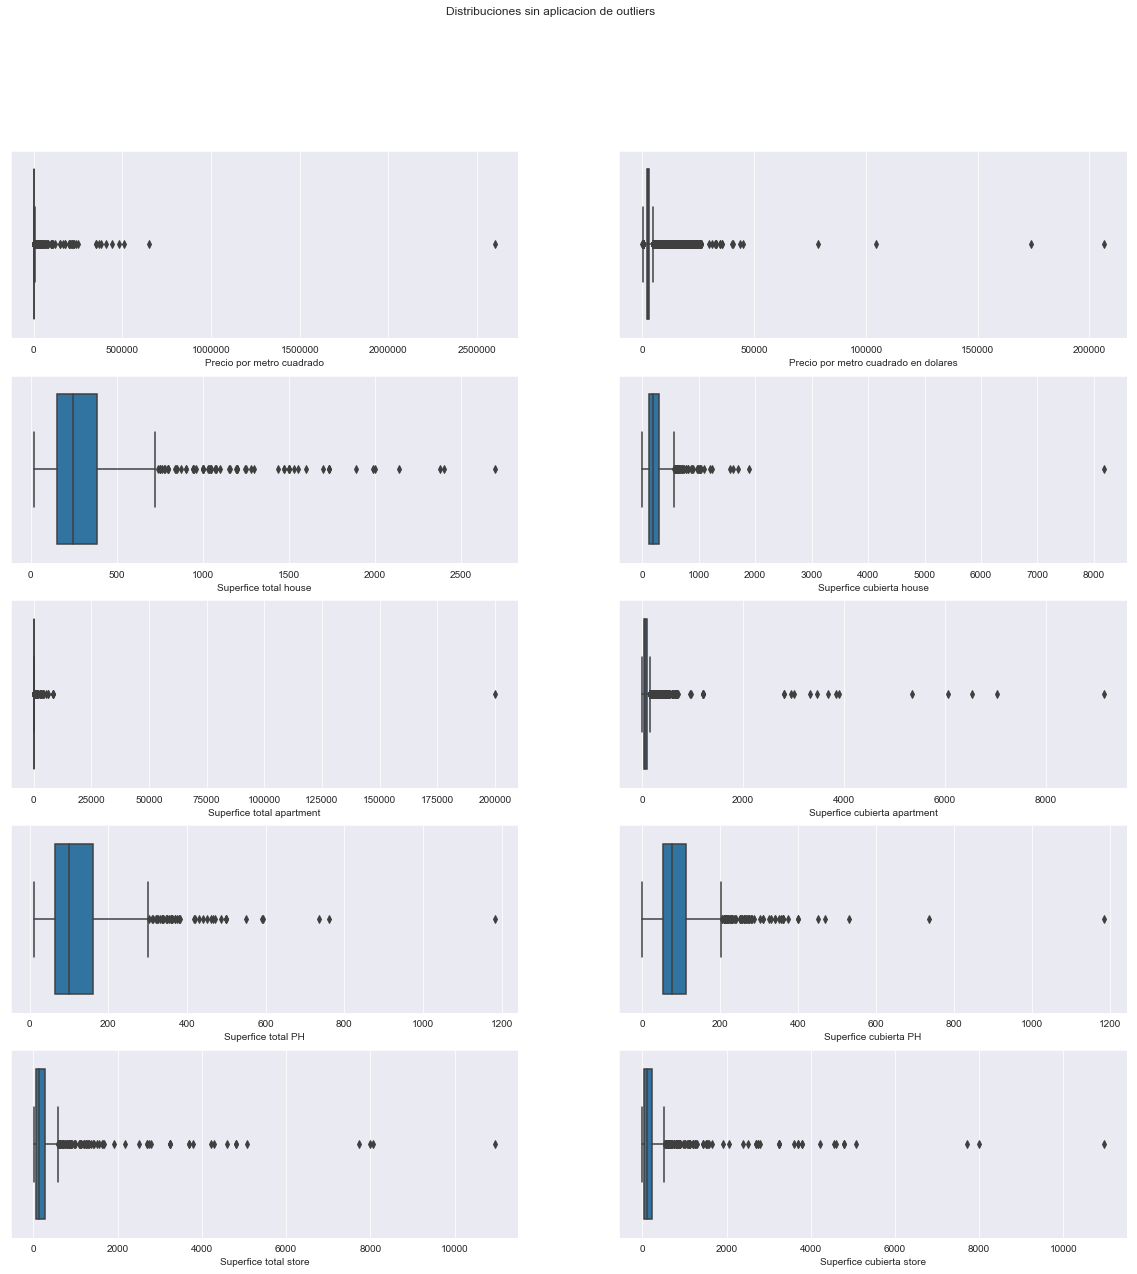

In [13]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(5,2,figsize=(20,20))
fig.suptitle('Distribuciones sin aplicacion de outliers')

sns.boxplot(x='price_per_m2', data=data, ax=axs[0,0])
axs[0,0].set(xlabel='Precio por metro cuadrado') 

sns.boxplot(x='price_usd_per_m2', data=data, ax=axs[0,1])
axs[0,1].set(xlabel='Precio por metro cuadrado en dolares')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_house, :], ax=axs[1,0])
axs[1,0].set(xlabel='Superfice total house')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_house, :], ax=axs[1,1])
axs[1,1].set(xlabel='Superfice cubierta house')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_apartment, :], ax=axs[2,0])
axs[2,0].set(xlabel='Superfice total apartment')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_apartment, :], ax=axs[2,1])
axs[2,1].set(xlabel='Superfice cubierta apartment')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_ph, :], ax=axs[3,0])
axs[3,0].set(xlabel='Superfice total PH')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_ph, :], ax=axs[3,1])
axs[3,1].set(xlabel='Superfice cubierta PH')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_store, :], ax=axs[4,0])
axs[4,0].set(xlabel='Superfice total store')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_store, :], ax=axs[4,1])
axs[4,1].set(xlabel='Superfice cubierta store')

plt.show()

Distribucion de amenities por barrio

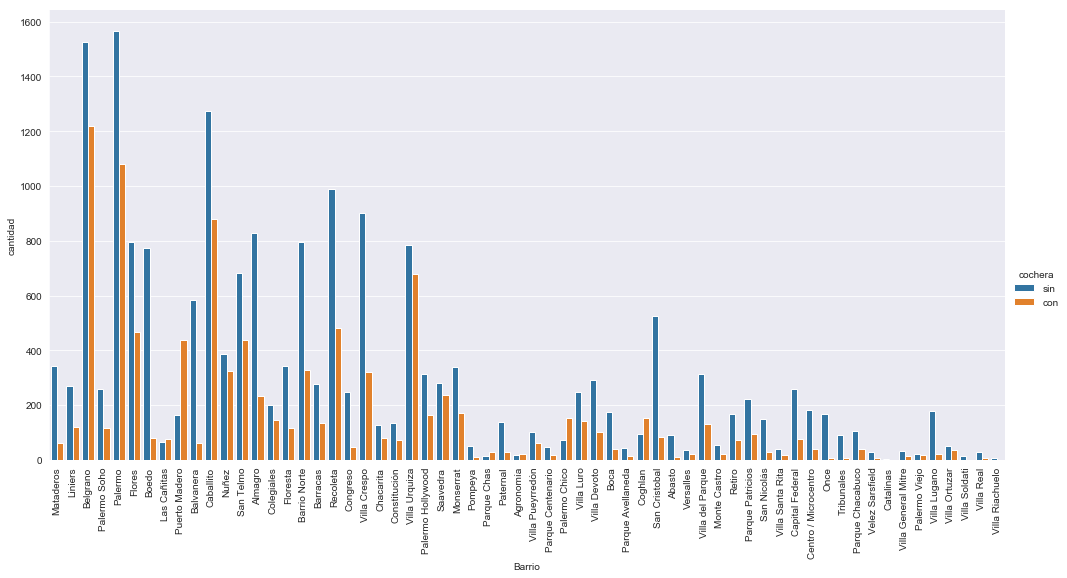

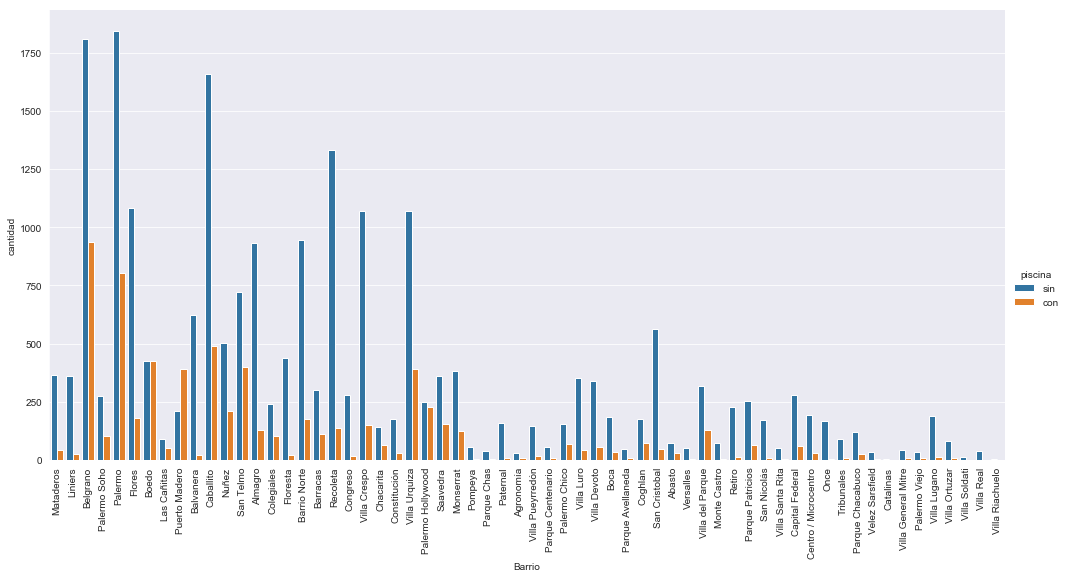

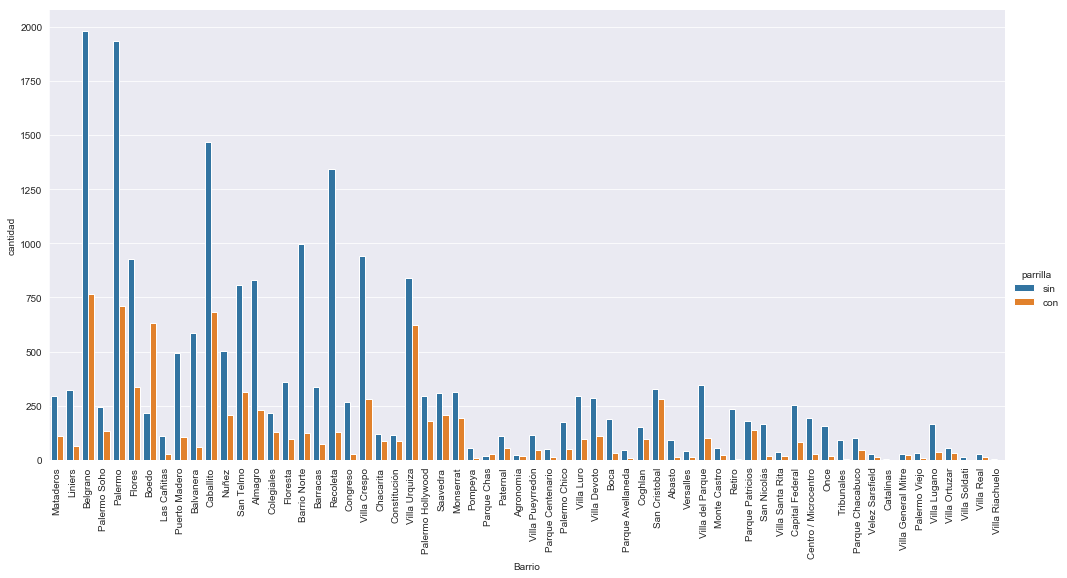

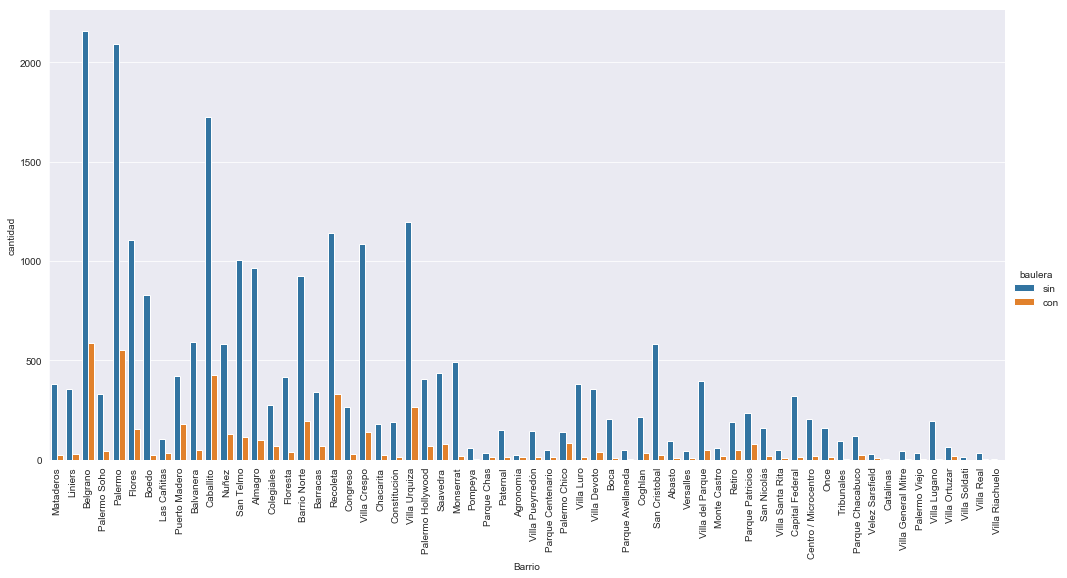

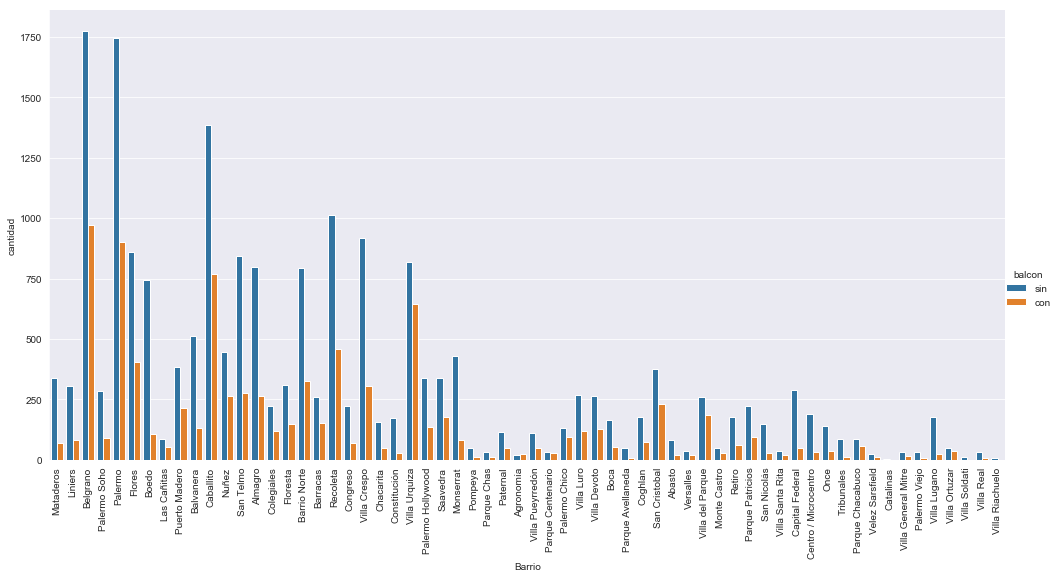

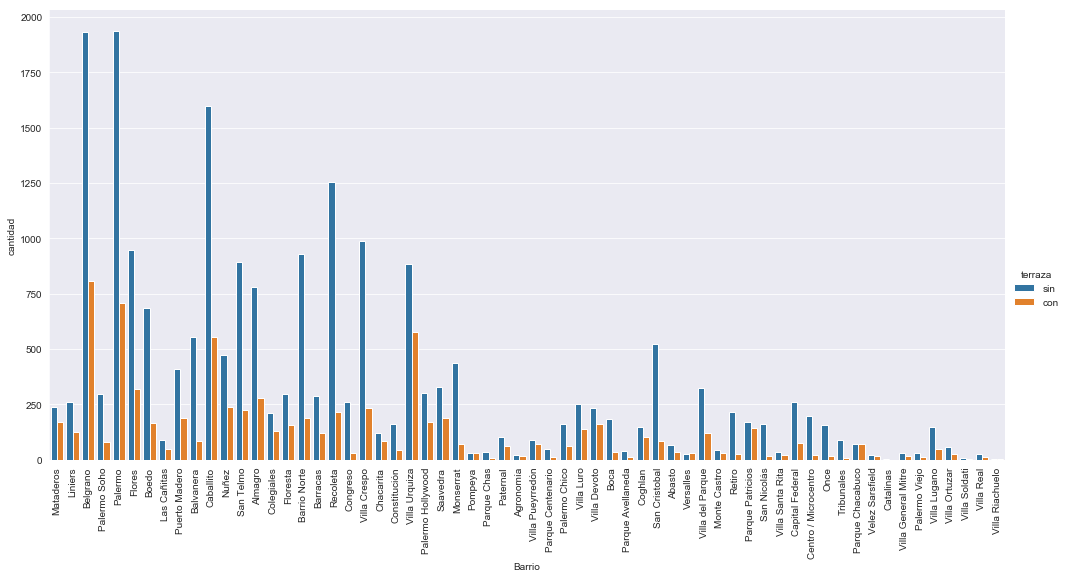

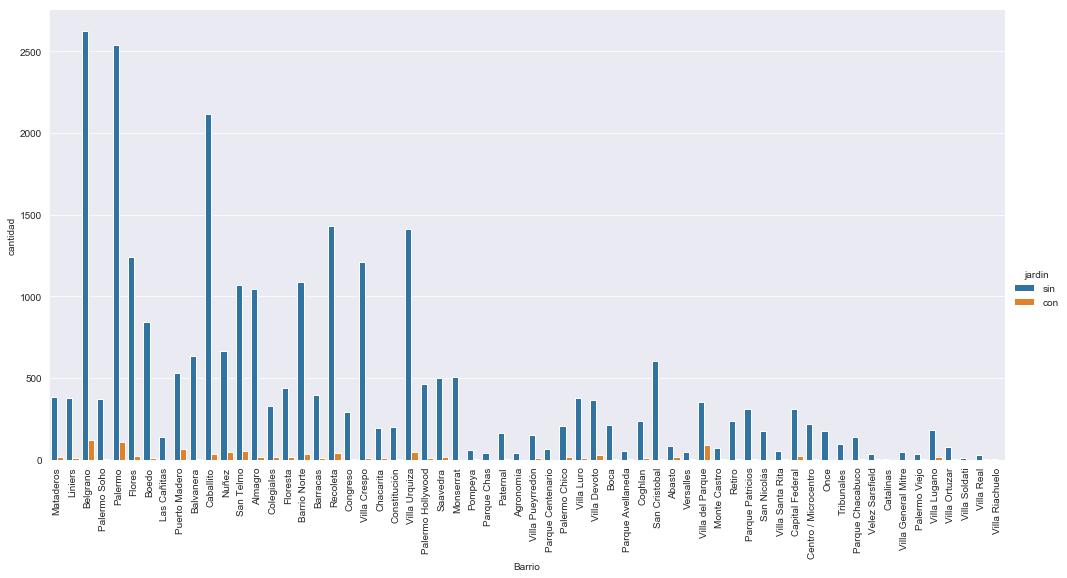

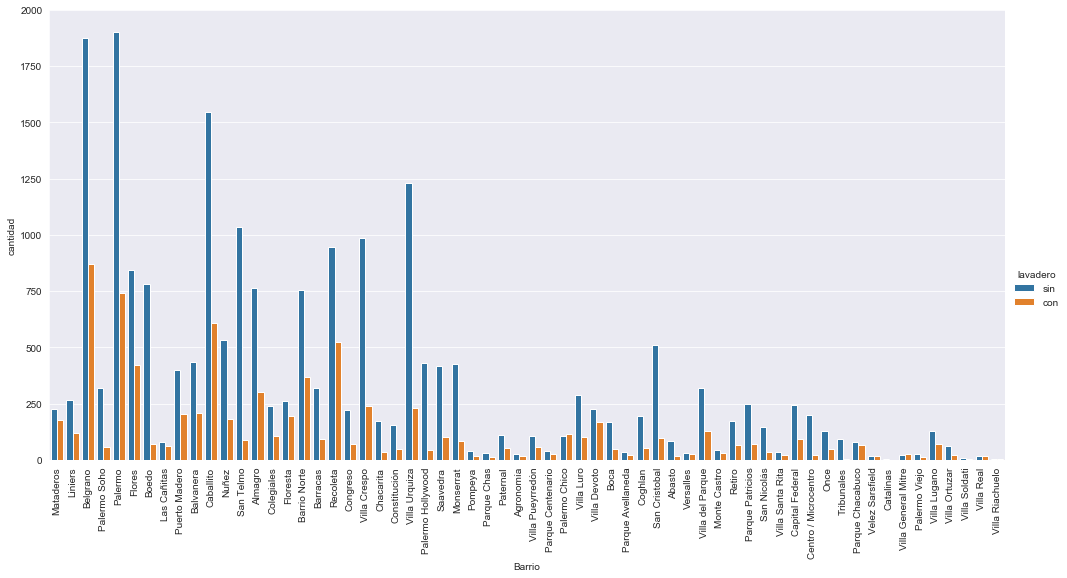

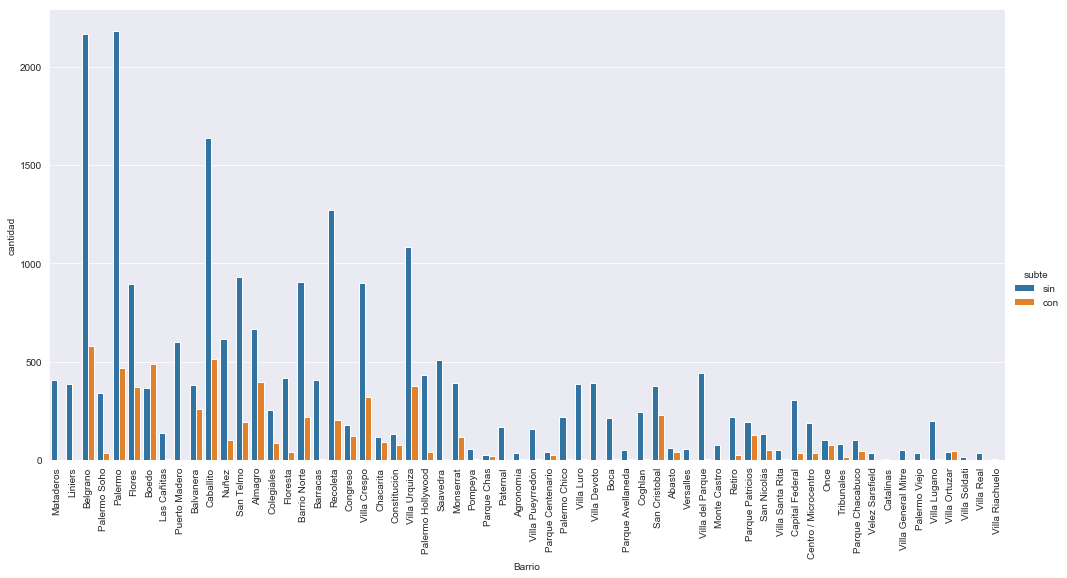

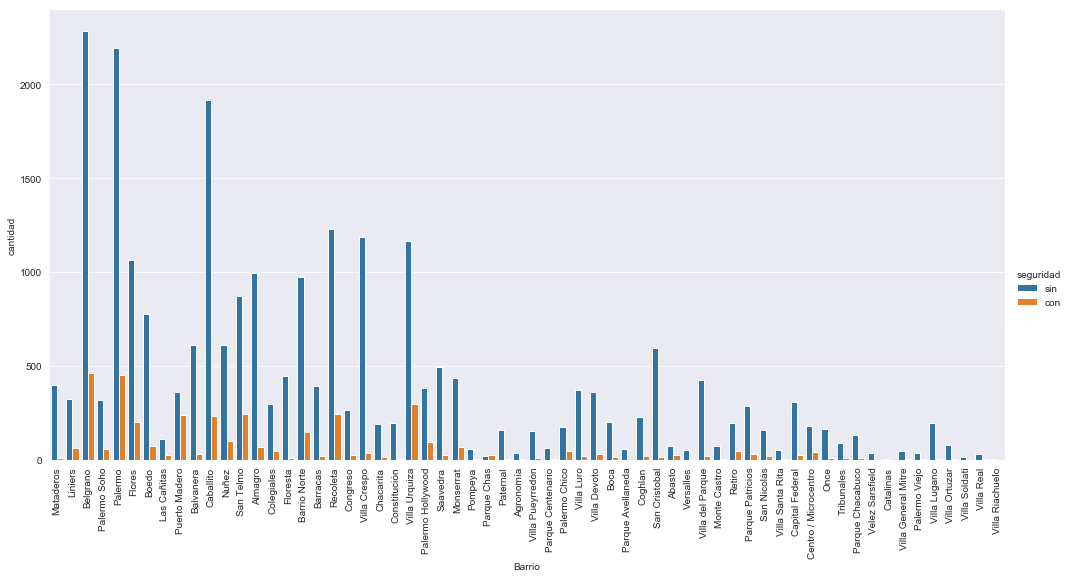

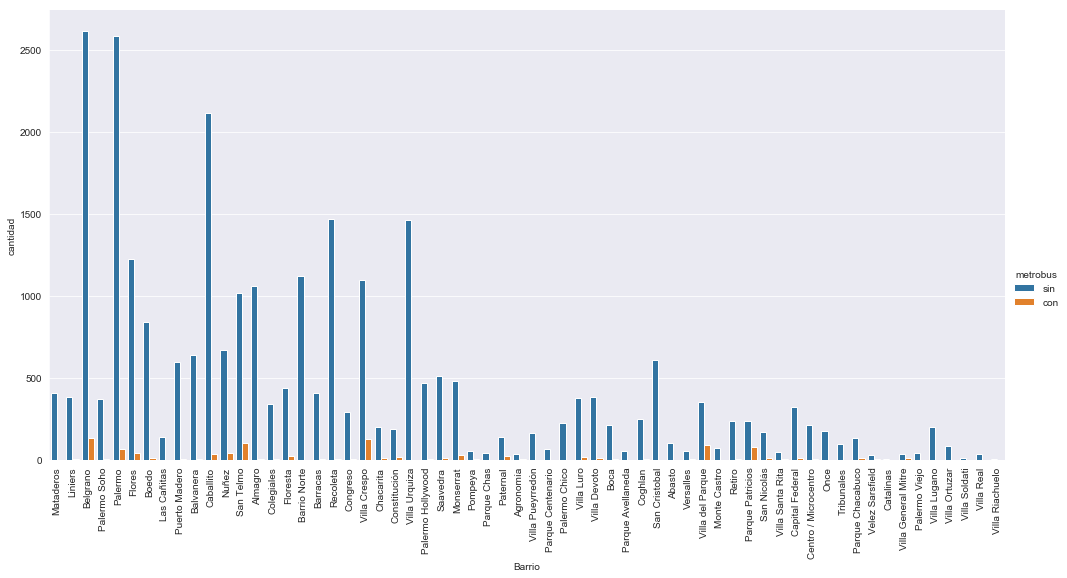

In [14]:
for x in data.columns[28:]:
    g = sns.catplot(x='place_name', hue=x, kind='count', data=data, height=7, aspect=2, legend_out=True)
    g.set_xticklabels(rotation=90)
    g.set(xlabel='Barrio', ylabel='cantidad')
    g._legend.set_title(x)
    new_labels = ['sin', 'con']
    for t, l in zip(g._legend.texts, new_labels): 
        t.set_text(l)

Correlacion entre variables numericas continuas con variable target.

In [15]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.299240,0.444095,0.675114,0.092777
price_usd_per_m2,0.299240,1.000000,-0.047114,-0.014624,0.534638
surface_covered_in_m2,0.444095,-0.047114,1.000000,0.658421,-0.021779
surface_total_in_m2,0.675114,-0.014624,0.658421,1.000000,0.038001
price_per_m2,0.092777,0.534638,-0.021779,0.038001,1.000000


Correlacion entre variables numericas discretas con variable target.

In [16]:
data.loc[:, ['price_usd_per_m2', 'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus']].corr()

,price_usd_per_m2,cochera,piscina,parrilla,baulera,terraza,jardin,lavadero,subte,seguridad,metrobus
price_usd_per_m2,1.000000,-0.006225,0.089500,0.162107,-0.004820,-0.050938,-0.006867,-0.087856,0.054266,0.054678,-0.037496
cochera,-0.006225,1.000000,0.268035,0.211302,0.299215,0.136142,0.065609,0.062795,-0.077577,0.233149,-0.029805
piscina,0.089500,0.268035,1.000000,0.379803,0.114733,0.109914,0.132456,-0.078120,0.004874,0.275207,-0.010327
parrilla,0.162107,0.211302,0.379803,1.000000,0.059655,0.284524,0.056150,-0.047983,0.035348,0.111212,-0.014175
baulera,-0.004820,0.299215,0.114733,0.059655,1.000000,0.080706,0.052823,0.210650,0.008817,0.187072,-0.004472
terraza,-0.050938,0.136142,0.109914,0.284524,0.080706,1.000000,0.076853,0.090028,-0.010656,0.094020,0.018945
jardin,-0.006867,0.065609,0.132456,0.056150,0.052823,0.076853,1.000000,0.057502,-0.042859,0.086155,0.054200
lavadero,-0.087856,0.062795,-0.078120,-0.047983,0.210650,0.090028,0.057502,1.000000,0.004940,0.047755,-0.014909
subte,0.054266,-0.077577,0.004874,0.035348,0.008817,-0.010656,-0.042859,0.004940,1.000000,0.026847,0.192602
seguridad,0.054678,0.233149,0.275207,0.111212,0.187072,0.094020,0.086155,0.047755,0.026847,1.000000,-0.009766


---

### Imputaciones

Caracteristicas:

Variables a imputar: surface_covered_in_m2, surface_total_in_m2, price_usd_per_m2, price_per_m2

Imputacion por mediana, segmentado por barrio y tipo de propiedad.

Para que se aplique la imputacion el porcentaje de nulos por barrio debera ser menor al 25% y no debera sobrepasar un umbral deliberado de desvio estandar
   
Se busca garantizar la maxima representatibidad de los datos a imputar

In [17]:
display(data.surface_covered_in_m2.isnull().value_counts())
display(data.surface_total_in_m2.isnull().value_counts())
display(data.price_usd_per_m2.isnull().value_counts())
display(data.price_per_m2.isnull().value_counts())

False    28210
True      1170
Name: surface_covered_in_m2, dtype: int64

False    25742
True      3638
Name: surface_total_in_m2, dtype: int64

False    22153
True      7227
Name: price_usd_per_m2, dtype: int64

False    26868
True      2512
Name: price_per_m2, dtype: int64

In [18]:
# Nulos de precio y superficie para revisar imputacion

price_usd_per_m2_null = data.price_usd_per_m2.isnull()
surface_total_in_m2_null = data.surface_total_in_m2.isnull()
surface_covered_in_m2_null = data.surface_covered_in_m2.isnull()
price_per_m2_null = data.price_per_m2.isnull()

In [19]:
nulos = price_usd_per_m2_null | surface_total_in_m2_null | surface_covered_in_m2_null | price_per_m2_null

dfimp = data.loc[nulos, ['Id_caso', 'place_name', 'property_type', 'price_usd_per_m2','price_per_m2','surface_total_in_m2','surface_covered_in_m2']]
dfimp.set_index("Id_caso", inplace = True)

dfimp.sample(3)

,place_name,property_type,price_usd_per_m2,price_per_m2,surface_total_in_m2,surface_covered_in_m2
Id_caso,,,,,,
32383,Monte Castro,PH,NaN,1384.62,190.0,130.0
7511,San Telmo,apartment,NaN,2654.00,300.0,40.0
47256,Palermo,apartment,NaN,1399.18,NaN,243.0


Identificamos los nulos sobre el dataframe de nulos generado

In [20]:
display(dfimp.price_usd_per_m2.isnull().value_counts())
display(dfimp.price_per_m2.isnull().value_counts())
display(dfimp.surface_covered_in_m2.isnull().value_counts())
display(dfimp.surface_total_in_m2.isnull().value_counts())

True     7227
False     837
Name: price_usd_per_m2, dtype: int64

False    5552
True     2512
Name: price_per_m2, dtype: int64

False    6894
True     1170
Name: surface_covered_in_m2, dtype: int64

False    4426
True     3638
Name: surface_total_in_m2, dtype: int64

In [21]:
# cantidad de nulos por barrios

data_porc_nulos = pd.DataFrame(dfimp["place_name"].value_counts())
data_porc_nulos.rename(columns = {"place_name":"nulos"}, inplace = True)
data_porc_todos = pd.DataFrame(data.place_name.value_counts())

#data_porc_todos
data_porc = pd.concat([data_porc_nulos, data_porc_todos], axis = 1)
data_porc["porc"] = (data_porc.nulos/data_porc.place_name * 100).round(2)
data_porc.rename(columns = {"place_name":"total"}, inplace = True)
data_porc.sort_values(by = ["porc"], ascending=False).head(5)

,nulos,total,porc
Catalinas,3,4,75.00
Parque Chas,29,44,65.91
Villa Soldati,9,14,64.29
Versalles,31,55,56.36
Liniers,204,386,52.85


In [22]:
data.loc[data.place_name == 'Abasto', 'price_usd_per_m2'].head(10).sort_values(ascending=False)

820     2142.86
173     1903.85
787     1708.86
1705    1615.38
3745    1558.14
1635    1274.50
782     1000.00
781     1000.00
779     1000.00
2590        NaN
Name: price_usd_per_m2, dtype: float64

In [23]:
#dfimp_p_m2_usd.property_type == 'Apartment'
dfimp.loc[dfimp.place_name == 'Abasto', 'price_usd_per_m2']

Id_caso
12842         NaN
25298         NaN
44340         NaN
45087         NaN
45787         NaN
45919         NaN
47762         NaN
47763         NaN
50139     1898.73
50140     1485.71
52901         NaN
56068         NaN
56069         NaN
59549         NaN
67149     1457.73
71972         NaN
71990         NaN
78447         NaN
81090     1900.00
84589         NaN
87483         NaN
109713        NaN
109769        NaN
Name: price_usd_per_m2, dtype: float64

In [24]:
dfimp.loc[dfimp.place_name == 'Abasto', 'surface_total_in_m2']

Id_caso
12842       NaN
25298       NaN
44340       NaN
45087      40.0
45787     100.0
45919      17.0
47762      95.0
47763      95.0
50139      79.0
50140      35.0
52901       NaN
56068      75.0
56069      75.0
59549       NaN
67149     343.0
71972       NaN
71990       NaN
78447      63.0
81090     200.0
84589       NaN
87483      50.0
109713    107.0
109769      NaN
Name: surface_total_in_m2, dtype: float64

In [25]:
col_imputacion = ['price_usd_per_m2','price_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2']
barrio = data.place_name.unique()

for c in col_imputacion:
    for b in barrio:
        for p in list(data.loc[data.place_name == b, 'property_type'].value_counts().index):
            barrio_prop_imp = data.loc[data.property_type == p, :].groupby('place_name')[c]
            if (data_porc.loc[data_porc.index == b, 'porc'][0] <= 25.00) & (barrio_prop_imp.std()[b] < 500): # valor deliberado
                
                nulos = dfimp[c].isnull()
                barrio = dfimp.place_name == b
                propiedad = dfimp.property_type == p
                dfimp.loc[nulos & barrio & propiedad, c] = barrio_prop_imp.median()[b]

In [26]:
# verificaciones varias
#dfimp.loc[dfimp.property_type == 'apartment', :].groupby('place_name')['surface_total_in_m2'].std()
dfimp.loc[dfimp.place_name == 'Abasto', 'surface_total_in_m2']

Id_caso
12842       NaN
25298       NaN
44340       NaN
45087      40.0
45787     100.0
45919      17.0
47762      95.0
47763      95.0
50139      79.0
50140      35.0
52901       NaN
56068      75.0
56069      75.0
59549       NaN
67149     343.0
71972       NaN
71990       NaN
78447      63.0
81090     200.0
84589       NaN
87483      50.0
109713    107.0
109769      NaN
Name: surface_total_in_m2, dtype: float64

In [27]:
dfimp.loc[dfimp.place_name == 'Abasto', 'price_usd_per_m2']

Id_caso
12842     2253.50
25298     2253.50
44340     2253.50
45087     2253.50
45787     2253.50
45919         NaN
47762     2253.50
47763     2253.50
50139     1898.73
50140     1485.71
52901     2253.50
56068     1457.73
56069     1457.73
59549     2253.50
67149     1457.73
71972     2253.50
71990     2253.50
78447     2253.50
81090     1900.00
84589         NaN
87483     2253.50
109713    2253.50
109769    2253.50
Name: price_usd_per_m2, dtype: float64

In [28]:
#dfimp_p_m2_usd.price_usd_per_m2.isnull().value_counts()
display(dfimp.price_usd_per_m2.isnull().value_counts())
display(dfimp.price_per_m2.isnull().value_counts())
display(dfimp.surface_covered_in_m2.isnull().value_counts())
display(dfimp.surface_total_in_m2.isnull().value_counts())

True     7081
False     983
Name: price_usd_per_m2, dtype: int64

False    5552
True     2512
Name: price_per_m2, dtype: int64

False    6894
True     1170
Name: surface_covered_in_m2, dtype: int64

False    4426
True     3638
Name: surface_total_in_m2, dtype: int64

In [29]:
# armamos df con los valores imputados para concatenar al data original
data.set_index("Id_caso", inplace = True)

# dfimp - 'price_usd_per_m2'
dfimp_price_usd_per_m2 = dfimp.drop(['place_name','property_type','price_per_m2','surface_total_in_m2','surface_covered_in_m2' ],axis=1)
dfimp_price_usd_per_m2.rename(columns = {'price_usd_per_m2': 'price_usd_per_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_price_usd_per_m2], axis = 1)

# dfimp - 'price_per_m2'
dfimp_price_per_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','surface_total_in_m2','surface_covered_in_m2'],axis=1)
dfimp_price_per_m2.rename(columns = {'price_per_m2': 'price_per_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_price_per_m2], axis = 1)

# dfimp - 'surface_total_in_m2'
dfimp_surface_total_in_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','price_per_m2','surface_covered_in_m2'],axis=1)
dfimp_surface_total_in_m2.rename(columns = {'surface_total_in_m2': 'surface_total_in_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_surface_total_in_m2], axis = 1)

# dfimp - 'surface_covered_in_m2'
dfimp_surface_covered_in_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','price_per_m2', 'surface_total_in_m2'],axis=1)
dfimp_surface_covered_in_m2.rename(columns = {'surface_covered_in_m2': 'surface_covered_in_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_surface_covered_in_m2], axis = 1)
data_imputac.drop(['surface_covered_in_m2_imputado'],axis=1, inplace=True)

In [30]:
data_imputac.columns

Index(['property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [31]:
data_imputac.shape

(29380, 38)

In [32]:
# imputamos los nulos de mt2 totales con los valores de mt2 cubiertos y lo mismo para las columnas de precio:

super_cub_no_nulo = data.surface_covered_in_m2.notnull()
data.loc[super_cub_no_nulo, "surface_total_in_m2"] = data.loc[super_cub_no_nulo, "surface_covered_in_m2"]

In [33]:
data = data_imputac.reset_index()

In [34]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [35]:
data.sample(3)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
18053,73961,apartment,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,"-34.5639010429,-58.4667872223",-34.563901,-58.466787,365000.0,USD,...,1.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0
23893,96353,apartment,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,NaN,NaN,NaN,186015.0,USD,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
2933,14497,apartment,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,"-34.589231,-58.4100648",-34.589231,-58.410065,390000.0,USD,...,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
data.shape

(29380, 39)

---

In [37]:
def remove_outlier(df_in, qt1, qt3, iqrout, col_name, mask1, var1, mask2=None, var2=None):
    '''
    Calculo de outliers

    Parameters
    ----------
    df_in : dataFrame
        dataFrame utilizado para extraer variables de filtro y mascaras.
    qt1, qt3: float
        Cuantil inferior y superior (0 a 1).
    iqrout: float
        Margen exterior a iqr (1.5 o 3 recomendado)
    var1, var2: str
        Nombre de columnas de dataFrame ingresado como parametro para aplicar filtro sobre los datos.
    mask1, mask2: str
        Valores para utilizar con las columnas de filtro para generar mascaras booleanas.
    col_name: str
        Variable a aplicar los outliers.
    
    Output
    ------
    dataFrame filtrado por parametros con los outliers aplicados.

    Example
    ----------
    remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', 'Belgrano', 'place_name', 'PH', 'property_type')
    
    '''
    
    if (mask2 is None and var2 is not None) | (mask2 is not None and var2 is None):
        return 'you must set second mask with second variable'
    elif mask2 is None and var2 is None:
        var_mask = df_in[var1] == mask1
    else:
        var_mask = (df_in[var1] == mask1) & (df_in[var2] == mask2)
        
    q1 = df_in.loc[var_mask, col_name].quantile(qt1)
    q3 = df_in.loc[var_mask, col_name].quantile(qt3)
    
    iqr = q3-q1 #Interquartile range
    
    fence_low  = q1-iqrout*iqr
    fence_high = q3+iqrout*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high) & var_mask]
    
    return df_out

In [38]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [39]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'price_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [40]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'surface_total_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [41]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'surface_covered_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [42]:
data = df_final

In [43]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.403822,0.552793,0.416518,0.123143
price_usd_per_m2,0.403822,1.000000,-0.046971,-0.069569,0.533497
surface_covered_in_m2,0.552793,-0.046971,1.000000,0.696318,-0.024366
surface_total_in_m2,0.416518,-0.069569,0.696318,1.000000,0.225558
price_per_m2,0.123143,0.533497,-0.024366,0.225558,1.000000


In [44]:
caba_place_name_mask = data.place_name != 'Capital Federal'
surface_total_in_m2_notnull = data.surface_total_in_m2.notnull()
surface_covered_mask_notnull = data.surface_covered_in_m2.notnull()
price_usd_per_m2_mask_notnull = data.price_usd_per_m2.notnull()

In [45]:
data = data.loc[caba_place_name_mask & surface_covered_mask_notnull & surface_total_in_m2_notnull & price_usd_per_m2_mask_notnull]

In [46]:
data.shape

(21081, 39)

In [47]:
property_type_dummies = pd.get_dummies(data.property_type, prefix='prop_type', drop_first = True)

data = pd.concat([data, property_type_dummies], axis=1)

In [48]:
place_name_dummies = pd.get_dummies(data.place_name, prefix='pn', drop_first = True)

data = pd.concat([data, place_name_dummies], axis=1)

In [49]:
nulos_piso = data.floor.isnull()
data.loc[nulos_piso, "floor" ] = 4

nulos_rooms = data.rooms.isnull()
data.loc[nulos_rooms, "rooms" ] = 2

In [50]:
erase_columns = ['property_type', 'place_with_parent_names', 'country_name', 'price_per_m2','state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name']

In [51]:
data = data.drop(data[erase_columns], axis=1)

In [52]:
data.columns

Index(['Id_caso', 'price_aprox_usd', 'floor', 'rooms', 'geonames_id',
       'price_usd_per_m2', 'surface_total_in_m2', 'surface_covered_in_m2',
       'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza',
       'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus',
       'prop_type_apartment', 'prop_type_house', 'prop_type_store',
       'pn_Agronomía', 'pn_Almagro', 'pn_Balvanera', 'pn_Barracas',
       'pn_Barrio Norte', 'pn_Belgrano', 'pn_Boca', 'pn_Boedo', 'pn_Caballito',
       'pn_Catalinas', 'pn_Centro / Microcentro', 'pn_Chacarita', 'pn_Coghlan',
       'pn_Colegiales', 'pn_Congreso', 'pn_Constitución', 'pn_Flores',
       'pn_Floresta', 'pn_Las Cañitas', 'pn_Liniers', 'pn_Mataderos',
       'pn_Monserrat', 'pn_Monte Castro', 'pn_Nuñez', 'pn_Once', 'pn_Palermo',
       'pn_Palermo Chico', 'pn_Palermo Hollywood', 'pn_Palermo Soho',
       'pn_Palermo Viejo', 'pn_Parque Avellaneda', 'pn_Parque Centenario',
       'pn_Parque Chacabuco', 'pn_Parque Chas', 'pn_Parque

---

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [54]:

model = LinearRegression(fit_intercept=True)

feature_cols = ['cochera', 'piscina',
       'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero',
       'prop_type_apartment', 'prop_type_house', 'prop_type_store',
       'pn_Agronomía', 'pn_Almagro', 'pn_Balvanera', 'pn_Barracas',
       'pn_Barrio Norte', 'pn_Belgrano', 'pn_Boca', 'pn_Boedo', 'pn_Caballito',
       'pn_Centro / Microcentro', 'pn_Chacarita', 'pn_Coghlan',
       'pn_Colegiales', 'pn_Congreso', 'pn_Constitución', 'pn_Flores',
       'pn_Floresta', 'pn_Las Cañitas', 'pn_Liniers', 'pn_Mataderos',
       'pn_Monserrat', 'pn_Monte Castro', 'pn_Nuñez', 'pn_Once', 'pn_Palermo',
       'pn_Palermo Chico', 'pn_Palermo Hollywood', 'pn_Palermo Soho',
       'pn_Palermo Viejo', 'pn_Parque Avellaneda', 'pn_Parque Centenario',
       'pn_Parque Chacabuco', 'pn_Parque Chas', 'pn_Parque Patricios',
       'pn_Paternal', 'pn_Pompeya', 'pn_Puerto Madero', 'pn_Recoleta',
       'pn_Retiro', 'pn_Saavedra', 'pn_San Cristobal', 'pn_San Nicolás',
       'pn_San Telmo', 'pn_Tribunales', 'pn_Velez Sarsfield', 'pn_Versalles',
       'pn_Villa Crespo', 'pn_Villa Devoto', 'pn_Villa General Mitre',
       'pn_Villa Lugano', 'pn_Villa Luro', 'pn_Villa Ortuzar',
       'pn_Villa Pueyrredón', 'pn_Villa Real', 'pn_Villa Riachuelo',
       'pn_Villa Santa Rita', 'pn_Villa Soldati', 'pn_Villa Urquiza',
       'pn_Villa del Parque']
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

MAE: 1142.04
MSE: 6638021.49
RMSE: 2576.44
R2: 0.37


In [55]:
r2_score(ytrain, ypred_train).round(2)

0.26

Fin depuracion dataframe y prueba inicial
---

---